In [6]:
import pandas as pd
from scipy.misc import derivative
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import macroparasites as mp
import scipy.interpolate as interp
from scipy.ndimage.filters import gaussian_filter
import scipy.stats as stats
import scipy.integrate as integrate

importlib.reload(mp)
plt.rcParams['figure.facecolor'] = "white"

## Analysis of of how aggregation following the partition model affects host-parasite dynamics

The following analyses are included in the manuscript *Dynamic parasite aggregation reduces parasite regulation of host populations and the stability of host-parasite interactions*

**Outline**

1. Comparison of Partition, Composition, and Poisson Model
2. Plotting the partition model predicted surface and exploring the power law approximation
3. Plot of regulation boundaries
4. Plot of stability boundaries

In [2]:
# Load in feasible set simulations
fs_results_flat = pd.read_pickle("../results/fs_results/simulated_fs_metrics.pkl")

MAX = 500
MIN = 3#1

# Build arrays for interpolation
INTERP_NUM = 1000 # Number of grid points to interpolate over. # Set to 1000 for a quicker interpolation
interp_vals = np.linspace(MIN, MAX, num=INTERP_NUM)
vals = np.arange(MIN, MAX + 1)

gridx, gridy = np.meshgrid(vals, vals)
pred_gridx, pred_gridy = np.meshgrid(interp_vals, interp_vals)

xs = gridx.ravel() # X are hosts
ys = gridy.ravel() # Y are parasites

# Indexing at 2 because I only want P, H >= 3
means = fs_results_flat['mean'][2:, 2:]
vars_fs = fs_results_flat['variance'][2:, 2:]

In [4]:
# Interpolate on a grid
vm = vars_fs.ravel() / means.ravel()

fit = interp.griddata(np.array([ys / xs, xs]).T, vm, 
            np.array([pred_gridy.ravel() / pred_gridx.ravel(), pred_gridx.ravel()]).T, method="nearest")

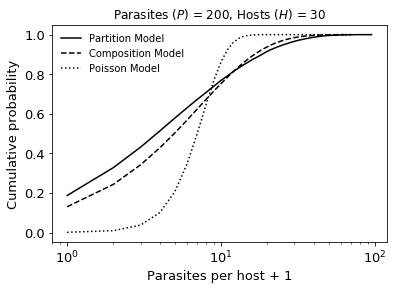

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
labelsize = 13

fs = np.loadtxt("temp_fs.txt")
fs_cdf = np.cumsum(pd.Series(fs.ravel()).value_counts().sort_index() / len(fs.ravel()))

mu = 200 / 30
k = 1
p = k / (mu + k)
xvals = np.arange(0, 70)
nbd = stats.nbinom.cdf(xvals, k, p)
pois = stats.poisson.cdf(xvals, mu)

ax.semilogx(fs_cdf.index.values + 1, fs_cdf.values, color="black", linestyle="-", label="Partition Model")
ax.semilogx(xvals + 1, nbd, color="black", linestyle="--", label="Composition Model")
ax.semilogx(xvals + 1, pois, color="black", linestyle=":", label="Poisson Model")
ax.set_xlabel("Parasites per host + 1", size=labelsize)
ax.set_ylabel("Cumulative probability", size=labelsize)
ax.tick_params(labelsize=13)
ax.legend(frameon=False)
ax.set_title("Parasites ($P$) = 200, Hosts ($H$) = 30")

fig.savefig("../results/partition_model_distribution.pdf", bbox_inches="tight")

### Plot the partition model variance to mean surface

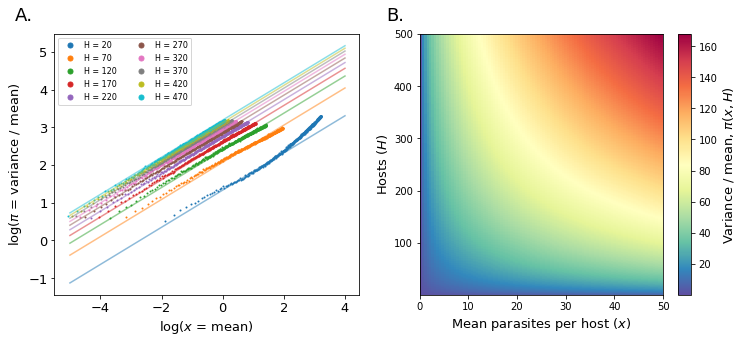

In [16]:
# Explore the variance to mean relationship
fig, axes = plt.subplots(1, 2, figsize=(12, 4.8))
axes = axes.ravel()
colors = sns.color_palette() + ['black']
labelsize = 13

xmeans = means.ravel()
yvarmeans = (vars_fs / means).ravel()
Hs = np.unique(xs)

# Save fits and Hs for visual exploration
fits = []
tH = []

Hvals = Hs[17:500:50] #np.array(list([25]) + list(Hs[47:500:50]))

handles = []
for j, H in enumerate(Hvals):
    
    ind = xs == H
    
    tH.append(H)
    tx = np.log(means.ravel()[ind])
    ty = np.log((vars_fs / means).ravel()[ind])
    axes[0].plot(tx, ty, 'o', ms=1)
    handles.append(plt.Line2D([1], [1], marker='o', markersize=5, linestyle="", 
                                  color=colors[j], label="H = {0}".format(H)))
    
    fits.append(stats.linregress(tx, ty))

# Extract intercepts and slopes
slopes = [f[0] for f in fits]
intercepts = [f[1] for f in fits]

int_reg = stats.linregress(np.log(tH), intercepts)

# Plot the approximation on top
axes[0].set_prop_cycle(None)

for H in Hvals:
    
    ind = xs == H
    
    tx = np.log(means.ravel()[ind])
    ty = np.log((vars_fs / means).ravel()[ind])
    
    intval = int_reg[0]*np.log(H) + int_reg[1]
    slope = slopes[-1] # Slopes converge after fluctuating start
    
    logmean = np.linspace(-5, 4, num=100)
    pred_logvarmean = intval + slope*logmean
    axes[0].plot(logmean, pred_logvarmean, '-', alpha=0.5)

axes[0].set_xlabel("log($x$ = mean)", size=labelsize)
axes[0].set_ylabel("log($\pi$ = variance / mean)", size=labelsize)
axes[0].tick_params(labelsize=13)
#axes[0].text(0.7, 0.1, "Approximate as \n\n $\pi(x, H) = cH^b x^z$", ha='center', transform=axes[0].transAxes)
axes[0].legend(handles, [a.get_label() for a in handles],  ncol=2, loc="upper left", prop={'size' : 8})

# Full approximation
mean_vals = np.linspace(0.01, 50, num=100)
Hvals = np.linspace(1, 500, num=1000)

X, Y = np.meshgrid(mean_vals, Hvals)
Z = mp.fs_varmean(Y, X)
plt.pcolormesh(X, Y, Z, cmap=plt.cm.Spectral_r)
cb = plt.colorbar()
cb.set_label("Variance / mean, $\pi(x, H)$", size=13)
axes[1].set_xlabel("Mean parasites per host ($x$)", size=labelsize)
axes[1].set_ylabel("Hosts ($H$)", size=labelsize)

axes[0].text(-0.1, 1.05, "A.", size=18, ha='center', transform=axes[0].transAxes)
axes[1].text(-0.1, 1.05, "B.", size=18, ha='center', transform=axes[1].transAxes)

fig.subplots_adjust(hspace=0.4)

fig.savefig("../results/feasible_surface.pdf", bbox_inches="tight")

### Plot of the intercept and slope relationships for the parition model surface

In [19]:
xmeans = means.ravel()
yvarmeans = (vars_fs / means).ravel()
Hs = np.unique(xs)

Hvals = Hs#[17:500:50] #np.array(list([25]) + list(Hs[47:500:50]))

fits = []
tH = []
handles = []
for j, H in enumerate(Hvals):
    
    ind = xs == H
    
    tH.append(H)
    tx = np.log(means.ravel()[ind])
    ty = np.log((vars_fs / means).ravel()[ind])

    fits.append(stats.linregress(tx, ty))

# Extract intercepts and slopes
slopes = [f[0] for f in fits]
intercepts = [f[1] for f in fits]

int_reg = stats.linregress(np.log(tH), intercepts)

for H in Hvals:
    
    ind = xs == H
    
    tx = np.log(means.ravel()[ind])
    ty = np.log((vars_fs / means).ravel()[ind])
    
    intval = int_reg[0]*np.log(H) + int_reg[1]
    slope = slopes[-1] # Slopes converge after fluctuating start

Text(0,0.5,'Exponent of power law')

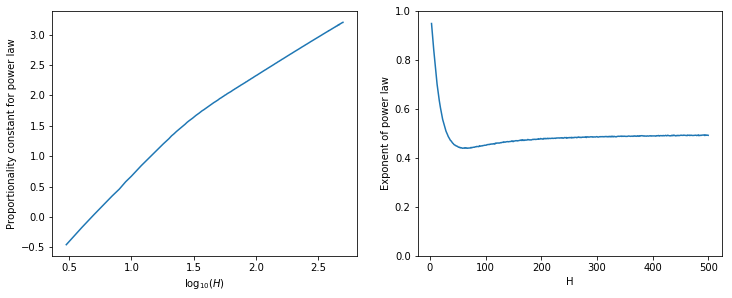

In [22]:
# Limiting behavior of partition model variance to mean relationship
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
axes = axes.ravel()

axes[0].plot(np.log10(tH), intercepts)
axes[0].set_xlabel("$\log_{10}(H)$")
axes[0].set_ylabel("Proportionality constant for power law")
axes[1].plot(tH, slopes)

axes[1].set_ylim(0, 1)
axes[1].set_xlabel("H")
axes[1].set_ylabel("Exponent of power law")

## Regulation boundaries

Compute and plot the regulation boundaries under the Fixed $k$ and Feasible Aggregation Model

/Users/mqwilber/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


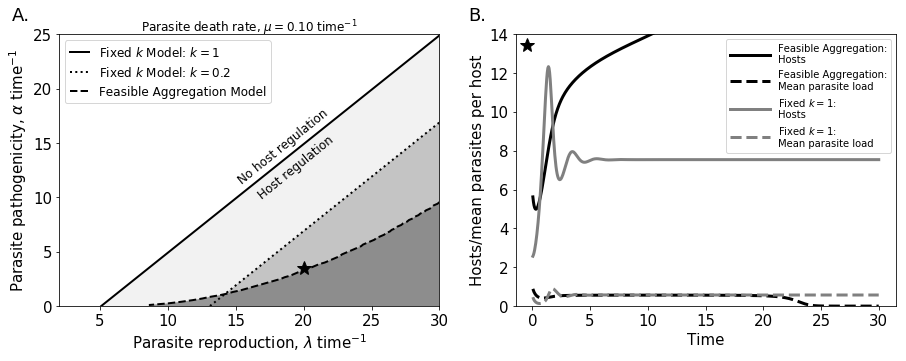

In [18]:
# Compute regulation boundaries
importlib.reload(mp)
mus = [0.1] # Parasite death rate

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.ravel()

for m, mu in enumerate(mus):
    
    params = {'b' : 3,
              'd' : 1,
              'alpha' : 0.5,
              'lam' : 19,
              'H0': 10,
              'k' : 1, 
              'mu': mu}

    alphas = np.linspace(0.01, 30, num=200)

    lams = []
    for alpha in alphas:
        params['alpha'] = alpha
        lams.append(mp.regulation_boundary(params))

    lams_fs = []
    params['k'] = 0.2

    for alpha in alphas:
        params['alpha'] = alpha
        lams_fs.append(mp.regulation_boundary(params))

    
    # Compute equilibrium for feasible model
    num = 200
    lams2 = np.linspace(2, 30, num=num)
    alphas2 = np.linspace(0.1, 30, num=num)[::-1]

    # Double for loop
    equil = np.empty((num, num))
    stable = np.empty((num, num))
    for i, alpha in enumerate(alphas2):
        for j, lam in enumerate(lams2):

            params['alpha'] = alpha
            params['lam'] = lam
            try:
                H_equil = mp.H_equil_fs(params, 0.01, 10)
                equil[i, j] = True
                jac = mp.feasible_jacobian(params, 0.01, 10)
                stable[i, j] = np.all(np.linalg.eigvals(jac) < 0)
            except:
                equil[i, j] = False
                stable[i, j] = False

    # Plot the results

    # Plot NBD model
    ax = axes[m]

    ind = np.array(lams) <= 33
    ax.plot(np.array(lams)[ind], np.array(alphas)[ind], '-', color="black", 
                    lw=2, label="Fixed $k$ Model: $k = 1$")
    ax.fill_between(np.array(lams)[ind], np.array(alphas)[ind], facecolor="gray", alpha=0.1)

    ind = np.array(lams_fs) <= 33
    ax.plot(np.array(lams_fs)[ind], np.array(alphas)[ind], ':', color="black", 
                    lw=2, label="Fixed $k$ Model: $k = 0.2$")
    ax.fill_between(np.array(lams_fs)[ind], np.array(alphas)[ind], facecolor="gray", alpha=0.4)

    # Plot FS model
    X, Y = np.meshgrid(lams2, alphas2)
    indexes = np.where(np.cumsum(equil, axis=1) == 1)
    lamvals = X[indexes]
    alphavals = Y[indexes]
    ax.plot(lamvals, alphavals, '--', color="black", lw=2, label="Feasible Aggregation Model")
    ax.fill_between(lamvals, alphavals, facecolor="gray", alpha=0.8)
    
    # Overlay stability
    # ax.pcolormesh(X, Y, stable)

    ax.set_xlabel(r"Parasite reproduction, $\lambda$ time$^{-1}$", size=15)
    
    if ax.is_first_col():
        ax.set_ylabel(r"Parasite pathogenicity, $\alpha$" + " time$^{-1}$", size=15)
        
    ax.set_xlim(2, 30)
    ax.set_ylim(0, 25)
    ax.tick_params(labelsize=15)
    ax.text(0.5, 1.01, "Parasite death rate, $\mu = {0:.2f}$".format(mu) + " time$^{-1}$", 
                        ha="center",
                        size=12, transform=ax.transAxes)
    
    if m == 0:
        ax.legend(prop={'size': 12}, handlelength=1.6, frameon=True)
    
    ax.plot(20, 3.5, '*', ms=15, color='black')


# Dynamic simulation
params['alpha'] = 3.5
params['lam'] = 20
params['k'] = 1

#He_fs = mp.H_equil_fs_repro(params, start=3, stop=100)
He = mp.H_equil(params)
me = mp.mean_equil(params)

ph_fxns = [([6, 1], mp.macroparasite_feasible), ([He - 5, me], mp.macroparasite_mean)]

dynamics = []
for init, fxn in ph_fxns:

    mod_mean = integrate.ode(fxn).set_integrator('zvode', method='bdf')

    t0 = 0
    t1 = 30
    dt = 0.05

    mod_mean.set_initial_value(init, t0).set_f_params(params)

    # Simulate mean model
    res_mean = []
    while mod_mean.successful() and mod_mean.t < t1:
        res_mean.append(np.r_[[mod_mean.t + dt], mod_mean.integrate(mod_mean.t + dt)])

    res_mean = np.array(res_mean)
    dynamics.append(res_mean)

axes[1].plot(0.03, 0.96, '*', ms=15, color='black', transform=axes[1].transAxes)
axes[1].plot(dynamics[0][:, 0], dynamics[0][:, 1], '-', lw=3, color="black", label="Feasible Aggregation:\nHosts")
axes[1].plot(dynamics[0][:, 0], dynamics[0][:, 2], '--', lw=3, color="black", label="Feasible Aggregation:\nMean parasite load")
axes[1].plot(dynamics[1][:, 0], dynamics[1][:, 1], '-', lw=3, color="gray", label="Fixed $k=1$:\nHosts")
axes[1].plot(dynamics[1][:, 0], dynamics[1][:, 2], '--', lw=3, color="gray", label="Fixed $k=1$:\nMean parasite load")
axes[1].set_ylim(0, 14)
axes[1].set_xlabel("Time", size=15)
axes[1].set_ylabel("Hosts/mean parasites per host", size=15)
axes[1].tick_params(labelsize=15)
axes[1].legend(loc="upper right", prop={'size': 10}, frameon=True, handlelength=4)

axes[0].text(15, 17.5, "No host regulation", size=12, rotation=39)
axes[0].text(16.5, 15, "Host regulation", size=12, rotation=39)

axes[0].text(-0.1, 1.05, "A.", size=18, ha='center', transform=axes[0].transAxes)
axes[1].text(-0.1, 1.05, "B.", size=18, ha='center', transform=axes[1].transAxes)
fig.savefig("../results/regulation_boundaries.pdf", bbox_inches="tight")

The entire region is stable as well, as predicted by Kretschmer and Adler (1993).

---

### Model predicted changes in equilibrium hosts and mean parasite load

Plotting changes in mean parasite load and the number of hosts under the Fixed k and Feasible Aggregation model.

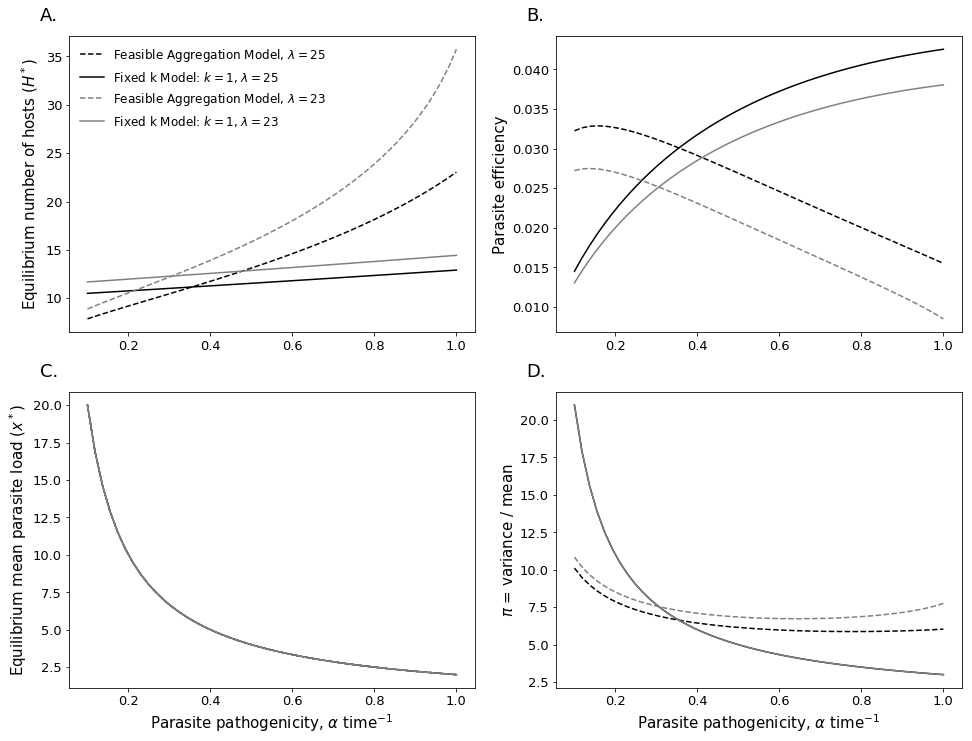

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

lambdas = [25, 23]
colors = ['black', "gray"]

# Loop over lambdas
for l, lam in enumerate(lambdas):
    
    params = {'b' : 3,
              'd' : 1,
              'alpha' : 0.3,
              'lam' : lam,
              'H0': 40,
              'k' : 1, 
              'mu': 0.1}

    alphas = np.linspace(0.1, 1)

    feas_res = []
    fixed_res = []
    for alpha in alphas:

        params['alpha'] = alpha
        Hfeas = mp.H_equil_fs(params, start=5, stop=50)
        Hfixed = mp.H_equil(params)

        mean_equil = mp.mean_equil(params)

        Pfeas = mean_equil * Hfeas
        Pfixed = mean_equil * Hfixed

        varmean_feas = mp.fs_varmean(Hfeas, mean_equil)
        varmean_fixed = 1 + (1 / params['k']) * mean_equil

        # Parasite efficiency...assume a negative binomial here which is a reasonable approximation
        k_feas = 1 / (varmean_feas - 1)*mean_equil
        k_fixed = params['k']
        p0_feas = (1 / (1 + mean_equil / k_feas))**k_feas
        p0_fixed = (1 / (1 + mean_equil / k_fixed))**k_fixed
        eff_feas = -np.log(p0_feas) / Pfeas
        eff_fixed = -np.log(p0_fixed) / Pfixed 

        feas_res.append((Hfeas, eff_feas, Pfeas / Hfeas, varmean_feas))
        fixed_res.append((Hfixed, eff_fixed, Pfixed / Hfixed, varmean_fixed))

    combo = zip(list(zip(*feas_res)), list(zip(*fixed_res)))
    statnames = ['Equilibrium number of hosts ($H^*$)', 'Parasite efficiency', 'Equilibrium mean parasite load ($x^*$)', '$\pi$ = variance / mean']
    letters = ["A.", "B.", "C.", "D."]
    
    for j, (stat1, stat2) in enumerate(combo):
                    
        ax = axes[j]
        ax.plot(alphas, stat1, '--', color=colors[l], label="Feasible Aggregation Model, $\lambda = {0}$".format(lam))
        ax.plot(alphas, stat2, '-', color=colors[l], label="Fixed k Model: $k = 1$, $\lambda = {0}$".format(lam))
        ax.set_ylabel(statnames[j], size=15)
        
        if ax.is_last_row():
            ax.set_xlabel(r"Parasite pathogenicity, $\alpha$ time$^{-1}$", size=15)
        ax.tick_params(labelsize=13)
        #ax.text(-0.05, 1.05, letters[j], size=18, ha='center', transform=ax.transAxes)

        if j == 0:
            ax.legend(prop={'size' : 12}, frameon=False)

for j in range(4):
    ax = axes[j]
    ax.text(-0.05, 1.05, letters[j], size=18, ha='center', transform=ax.transAxes)
    
fig.savefig("../results/host_suppression.pdf", bbox_inches="tight")

## Effect of parasite load on stability 

Performing stability analysis on the Fixed $k$ and Feasible Aggregation Model.

In [127]:
importlib.reload(mp)
import scipy.integrate as integrate
params = {'b' : 3,
              'd' : 1,
              'alpha' : 0.3,
              'lam' : 35,
              'H0': 40,
              'k' : 1, 
              'mu': 0.1,
              'xi': 0.13}



num = 200
alphas = np.linspace(0.001, 0.6, num=num)
xis = np.linspace(0.01, 0.1, num=num)[::-1]
lambdas = [15, 10, 10]
ks = [1, 1, 0.5]

jac_fxns = [mp.mean_repro_jacobian, mp.feasible_repro_jacobian]

allres = {}

for l, lam in enumerate(lambdas):
    
    allstable = []
    for fxn in jac_fxns:

        stable = np.empty((num, num))

        for i, xi in enumerate(xis):
            for j, alpha in enumerate(alphas):

                params['alpha'] = alpha
                params['xi'] = xi
                params['lam'] = lam
                params['k'] = ks[l]

                try:
                    jac = fxn(params, start=0.02, stop=70)

                    eigs = np.linalg.eigvals(jac)

                    if np.all(eigs < 0):
                        stable[i, j] = True
                    else:
                        stable[i, j] = False
                except:
                    stable[i, j] = False

        allstable.append(stable)
        
    allres[str(lam) + "_" + str(ks[l])] = allstable

/Users/mqwilber/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mqwilber/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:963: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 1] = interval


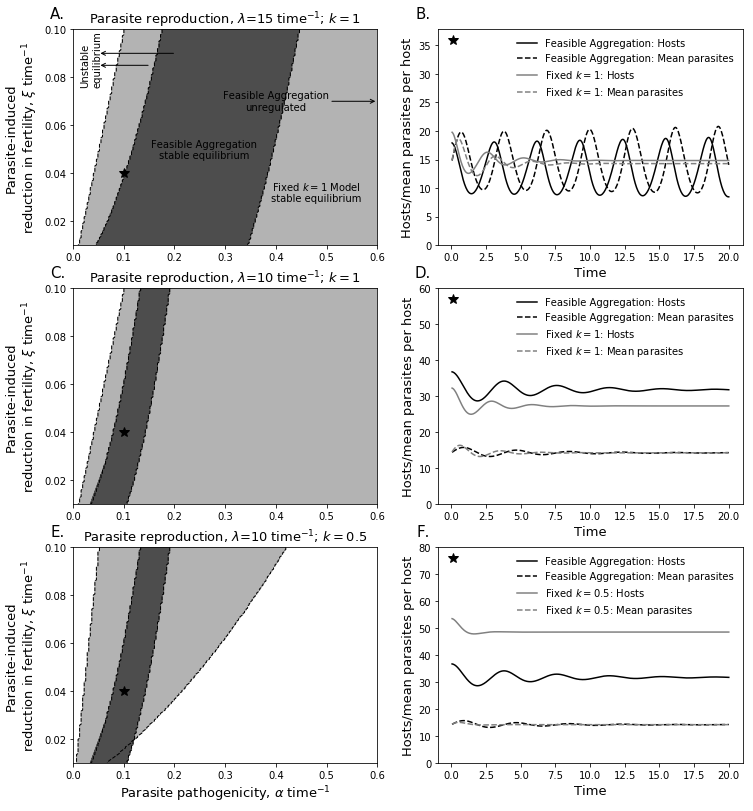

In [129]:
from matplotlib.patches import Polygon
fig, axes = plt.subplots(3, 2, figsize=(12, 13.5), sharey=False)
axes = axes.ravel()

axes_phase = [axes[0], axes[2], axes[4]]
axes_dyn = [axes[1], axes[3], axes[5]]
colors = ['0.7', '0.3']

for j, lam in enumerate(allres.keys()):
    
    ax = axes_phase[j]
    for i in range(len(allstable)):

        X, Y = np.meshgrid(alphas, xis)

        stable = allres[lam][i]

        # Plot left most edges
        indexes = np.where(np.cumsum(stable, axis=1) == 1) 
        alphavals = X[indexes]
        xivals = Y[indexes]
        ax.plot(alphavals, xivals, '--', lw=1, color='black')

        # Plort right most edges
        edge2 = np.sum(stable, axis=1)[:, np.newaxis] - np.cumsum(stable, axis=1)
        indexes = list(np.where(edge2 == 1))

        try:
            indexes[1] = indexes[1] + 2
            alphavals2 = X[indexes]
        except:
            indexes[1] = indexes[1] - 1
            alphavals2 = X[indexes] 
        xivals2 = Y[indexes]
        ax.plot(alphavals2, xivals2, '--', lw=1, color='black')

        # Specify bounding for polygon
        num=2
        topx = np.linspace(np.max(alphavals), np.max(alphavals2), num=num)
        topy = np.repeat(np.max(xivals), len(topx))
        bottomx = np.linspace(np.min(alphavals), np.min(alphavals2), num=num)
        bottomy = np.repeat(np.min(xivals), len(bottomx))

        # Make and fill polygon
        xys = list(zip(topx, topy)) + list(zip(bottomx, bottomy)) + \
                list(zip(alphavals, xivals)) + list(zip(alphavals2, xivals2))
        poly = Polygon(xys, facecolor=colors[i], edgecolor=colors[i], closed=True, linestyle=None)
        ax.add_patch(poly)


    #     ax.pcolormesh(X, Y, stable, visible=False,
    #                            alpha=0.3, linewidth=0)
        ax.set_xlim(0, np.max(alphas))
        ax.set_ylim(np.min(xis), np.max(xis))
        
        ax.set_ylabel("Parasite-induced\nreduction in fertility," + r" $\xi$ time$^{-1}$", size=13)
        if ax.is_last_row():
            ax.set_xlabel(r"Parasite pathogenicity, $\alpha$ time$^{-1}$", size=13)
        
        ax.set_title(r"Parasite reproduction, $\lambda$={0}".format(lam.split("_")[0]) + 
                                         " time$^{-1}$" + "; $k = {0}$".format(lam.split("_")[1]), size=13)

ax = axes_phase[0]
ax.text(0.43, 0.4, "Feasible Aggregation\nstable equilibrium", ha='center', 
                    transform=ax.transAxes)
ax.text(0.8, 0.2, "Fixed $k=1$ Model\nstable equilibrium", ha='center', 
                    transform=ax.transAxes)

ax.annotate('Feasible Aggregation\nunregulated',
             ha="center", va="center",
             xy=(0.6, 0.07), xytext=(0.4, 0.07),
             arrowprops=dict(arrowstyle="->",  facecolor='black', shrinkA=1))

ax.annotate('',
             ha="center", va="center",
             xy=(0.05, 0.09), xytext=(0.2, 0.09),
             arrowprops=dict(arrowstyle="->",  facecolor='black', shrinkA=1))

ax.annotate('',
             ha="center", va="center",
             xy=(0.05, 0.085), xytext=(0.15, 0.085),
             arrowprops=dict(arrowstyle="->",  facecolor='black', shrinkA=1))

ax.text(0.015, 0.0875, "Unstable\nequilibrium", rotation=90, va='center')


## Plot Model dynamics

for l, lam in enumerate(lambdas):
    
    params['alpha'] = 0.1
    params['xi'] = 0.04
    params['lam'] = lam
    params['k'] = ks[l]
    ax = axes_dyn[l]
    
    He_fs = mp.H_equil_fs_repro(params, start=3, stop=100)
    He = mp.H_equil_repro(params, start=3, stop=100)
    me = mp.mean_equil_repro(params)

    ph_fxns = [([He_fs + 5, me], mp.macroparasite_feasible_repro), ([He + 5, me], mp.macroparasite_mean_repro)]

    dynamics = []
    for init, fxn in ph_fxns:

        mod_mean = integrate.ode(fxn).set_integrator('zvode', method='bdf')

        t0 = 0
        t1 = 20
        dt = 0.05

        mod_mean.set_initial_value(init, t0).set_f_params(params)

        # Simulate mean model
        res_mean = []
        while mod_mean.successful() and mod_mean.t < t1:
            res_mean.append(np.r_[[mod_mean.t + dt], mod_mean.integrate(mod_mean.t + dt)])

        res_mean = np.array(res_mean)
        dynamics.append(res_mean)
    
    ax.plot(dynamics[0][:, 0], dynamics[0][:, 1], '-', color="black", 
                                                label="Feasible Aggregation: Hosts")
    ax.plot(dynamics[0][:, 0], dynamics[0][:, 2], '--', color="black",
                                                label="Feasible Aggregation: Mean parasites")
    
    ax.plot(dynamics[1][:, 0], dynamics[1][:, 1], '-', color='gray',  
                                                    label="Fixed $k = {0}$: Hosts".format(ks[l]))
    ax.plot(dynamics[1][:, 0], dynamics[1][:, 2], '--', color="gray", 
                                                    label="Fixed $k = {0}$: Mean parasites".format(ks[l]))
    
    if l == 0:
        ax.set_ylim(0, np.max(dynamics[0][1, 1:] + 20))
    
    if l == 1:
        ax.set_ylim(0, 60)
    
    if l == 2:
        ax.set_ylim(0, 80)
    
    ax.legend(frameon=False)
    ax.set_xlabel("Time", size=13)
    ax.set_ylabel("Hosts/mean parasites per host", size=13)
    ax.plot(0.05, 0.95, "*", ms=10, color="black", transform=ax.transAxes)
    axes_phase[l].plot([params['alpha']], [params['xi']], '*', ms=10, color="black")

letters = ['A.','B.', 'C.', 'D.', 'E.', "F."]
for j, ax in enumerate(axes):
    ax.text(-0.05, 1.05, letters[j], size=15, ha='center', transform=ax.transAxes)

fig.savefig("../results/stability_results.pdf", bbox_inches="tight")